In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/lyric_generator/'

[Errno 2] No such file or directory: '/content/drive/MyDrive/lyric_generator/'
/content


## Introduction

In recent years, there has been a surge in the application of artificial intelligence (AI) techniques to various creative domains. One fascinating area is the generation of album covers for music albums. In this article, we explore the use of AI models to generate album covers specifically tailored to Taylor Swift's lyrics dataset. We employ the T5 model for generating song summaries from lyrics and utilize diffusion models to create unique and visually captivating album covers. Let's dive deeper into these two approaches.

**T5 Model for Generating Song Summaries from Lyrics:**

The T5 (Text-To-Text Transfer Transformer) model is a powerful natural language processing (NLP) model developed by Google. It can be fine-tuned for various tasks, including text summarization. In our case, we leverage the T5 model to generate concise and meaningful summaries of Taylor Swift's lyrics. By inputting a set of lyrics into the T5 model, we can obtain a summary that captures the essence of the song, providing a glimpse into its theme or emotions.

**Diffusion Models for Album Cover Generation:**

Diffusion models have gained popularity in the field of generative modeling. These models use a diffusion process to gradually generate high-quality and diverse samples. We utilize diffusion models to generate visually appealing album covers that align with the themes and emotions extracted from the song summaries generated by the T5 model. By leveraging the power of diffusion models, we can create unique and artistic album covers that reflect the essence of Taylor Swift's music.


In [3]:
!pip install diffusers transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#!pip uninstall -y transformers accelerate

In [5]:
import os
import re
import torch
from sklearn.model_selection import train_test_split


In [6]:
def preprocess(text):
    punctuation_pad = '!?.,:-;'
    content = re.sub(r'\n\n',r"<EOV>", text)
    content = re.sub(r'\n', r"<EOS>", content)
    content = re.sub(r'\|.*?\|','',content)
    content = content.translate(str.maketrans({key: ' {0} '.format(key) for key in punctuation_pad}))
    content = re.sub(' +', ' ', content)
    content = re.split(r'(<EOS>)|(<EOV>)',content)
    updated_content = ['' if element is None else element for element in content]
    return ' '.join(updated_content)

In [7]:
path = '/content/drive/MyDrive/lyrics_generator/Data/' 

all_lyrics = []
for filename in os.listdir(path):
    with open(os.path.join(path, filename), "r") as f:
        lyrics = f.read()
        preprocess_lyrics = preprocess(lyrics) 
        all_lyrics.append(preprocess_lyrics)

In [8]:
all_lyrics[0]

"Verse 1 <EOS>  Is it romantic how all my elegies eulogize me ?  <EOS>  I'm not cut out for all these cynical clones <EOS>  These hunters with cell phones  <EOV> Chorus <EOS>  Take me to the Lakes where all the poets went to die <EOS>  I don't belong and , my beloved , neither do you <EOS>  Those Windermere peaks look like a perfect place to cry <EOS>  I'm setting off , but not without my muse <EOS>  Verse 2 <EOS>  What should be over burrowed under my skin <EOS>  In heart - stopping waves of hurt <EOS>  I've come too far to watch some namedropping sleaze <EOS>  Tell me what are my words worth  <EOV> Chorus <EOS>  Take me to the Lakes where all the poets went to die <EOS>  I don't belong and , my beloved , neither do you <EOS>  Those Windermere peaks look like a perfect place to cry <EOS>  I'm setting off , but not without my muse  <EOV> Bridge <EOS>  I want auroras and sad prose <EOS>  I want to watch wisteria grow right over my bare feet <EOS>  'Cause I haven't moved in years <EOS>  

In [9]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [10]:
# Load the pre-trained T5 model and tokenizer
model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [11]:
# Set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

# Function to generate the summary
def generate_summary(text):
    # Preprocess the input text
    input_text = 'summarize: ' + text
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

    # Generate the summary
    summary_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
    summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)

    return summary


In [12]:
import random
import pandas as pd

In [13]:
#load the songs and album titles
songs_cover = pd.read_csv('/content/drive/MyDrive/lyrics_generator/songs_cover.csv')
songs_cover.head()

,song_title,album_name
0,1989_Booklet_,1989
1,Style,1989
2,HowYouGetTheGirl,1989
3,IWishYouWould,1989
4,BlankSpace,1989


### Generating Summary and Album Cover

For randomly choosen album, we generate the album cover.

- First we generate the summary from all the songs. For this, we use T5 model (not fine-tuned for Taylor's Swift data).
- Use above generated summary and use diffusion models to generate the Album cover.

In [30]:
random.seed(42)
album = random.choice(songs_cover.album_name.to_list())
print(album)
file_names = songs_cover.loc[songs_cover.album_name == album].song_title.to_list()
print(file_names)

Reputation
['DancingWithOurHandsTied', 'Delicate', 'NewYearsDay', 'Gorgeous', 'WhySheDisappeared_Poem_', 'CallItWhatYouWant', 'IfYoureAnythingLikeMe_Poem_', 'EndGame', 'Reputation_Prologue_', 'LookWhatYouMadeMeDo', 'GetawayCar', 'IDidSomethingBad', '___ReadyforIt_', 'ReputationMagazineVol_1', 'Dress', 'KingofMyHeart', 'ThisIsWhyWeCantHaveNiceThings', 'SoItGoes___', 'DontBlameMe']


In [32]:
#text files path
file_paths = "/content/drive/MyDrive/lyrics_generator/Data/"

In [33]:
gen_summary = ' '
for file in file_names:
  file_path = os.path.join(file_paths, album+file+'.txt')
  with open(file_path, 'r') as f:
    txt = f.read()
    summary = generate_summary(txt)
    gen_summary += summary 


In [34]:
gen_summary

' we were dancing with our hands tied, hands tied Yeah, we were dancing Like it was the first time Yeah, we were dancing Dancing with our hands tied, hands tied Yeah, we were dancing And I had a bad feeling But we were dancing.\'Cause I know that it\'s delicate Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isn\'t it? Isni\'ll be cleaning up bottles with you on new year\'s day Post-Chorus Hold on to the memories, they will hold on to you Hold on to the memories, they will hold on to you And I will hold on to you Outro Please, don\'t ever become a stranger To the memories, they will hold on to you Whose laugh I could recognize anywhere.you\'re so gorgeous I can\'t say anything to your face \'Cause look at your face Look at your face, gorgeous And I\'m so furious I\'m so furious At you for making me feel this way But what can I say? Oh Chorus You\'re so gorgeous I can\'t say anything to your f

### Generating Album Cover

In [18]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import accelerate

In [20]:
from diffusers import DiffusionPipeline

In [21]:
generator = DiffusionPipeline.from_pretrained("CompVis/ldm-text2im-large-256")

The config attributes {'timestep_values': None} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [22]:
generator.to(device)

LDMTextToImagePipeline {
  "_class_name": "LDMTextToImagePipeline",
  "_diffusers_version": "0.16.1",
  "bert": [
    "latent_diffusion",
    "LDMBertModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "tokenizer": [
    "transformers",
    "BertTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vqvae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [35]:
image = generator(gen_summary).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [36]:
album

'Reputation'

In [37]:
image.save(f"{album}.png")

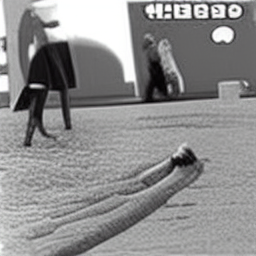

In [38]:
#generated images
from PIL import Image

# Open the image file
image_path = '/content/Reputation.png'
image = Image.open(image_path)

# Display the image
image.show()


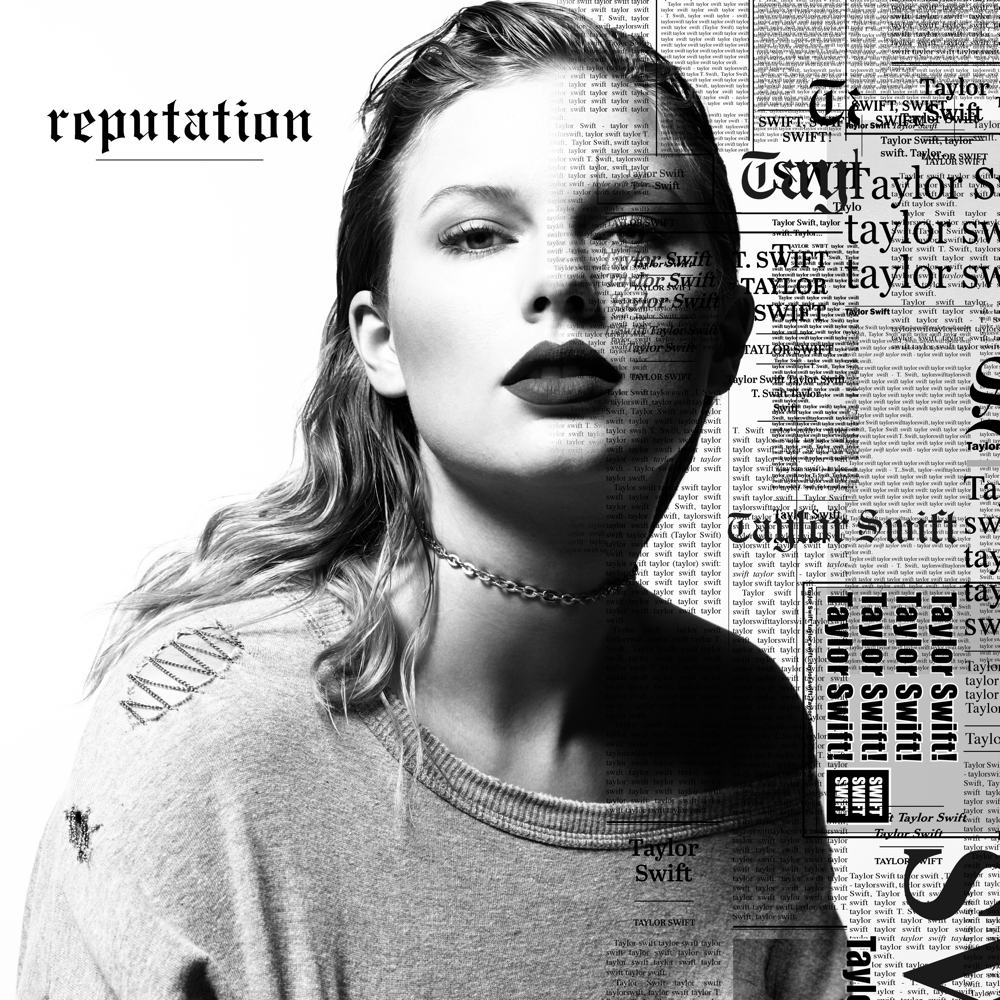

In [31]:
#original image
from PIL import Image

# Open the image file
image_path = '/content/drive/MyDrive/lyrics_generator/data/Cover_Art/Reputation.jpg'
image = Image.open(image_path)

# Display the image
image.show()


### Conclusions:

- The results displayed for not fine-tuned for Taylor's Swift Lyrics.
- The result will improve if T5 fine-tuned with Taylor's Swift Lyrics dataset.